In [120]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
from calcwf import shifted_f, shifted_e, P_from_f, num_orbits, peri_advance_orbit, gen_wf, trim_wf, chirp2total, get_h, overlap_cplx_wfs

# Generate training data

In [95]:
# Generates n training waveforms equally spaced in true anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    # Check if both h_ap and h_peri included
    if n%2 == 1:
        print('Both h_ap and h_peri are included only if an even number of training waveforms are requested.')

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = +np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, training_wfs[0])
            
        training_wfs.append(h)

        # Progress bar
        print(f'\r{i+1} done out of {n}.', end='')

    return training_wfs

In [99]:
training_wfs = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 100, 4096, 'TEOBResumS')

100 done out of 100.

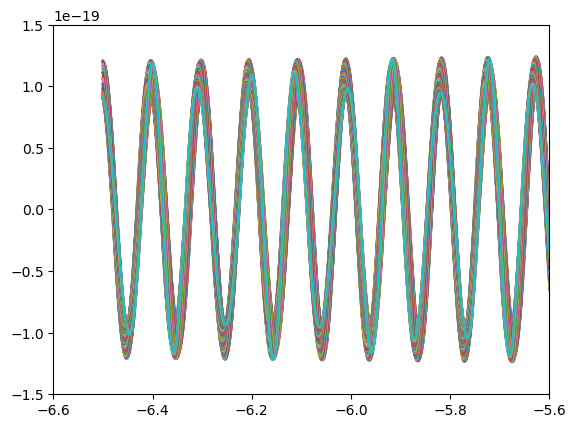

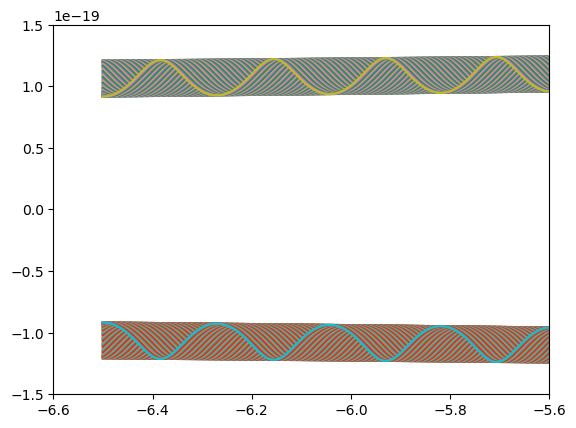

In [113]:
for i, wf in enumerate(training_wfs):
    plt.plot(wf.sample_times, wf)
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

for i, wf in enumerate(training_wfs):
    plt.plot(wf.sample_times, np.sqrt(wf.real()**2+wf.imag()**2))
    plt.plot(wf.sample_times, -np.sqrt(wf.real()**2+wf.imag()**2))
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

# Performing PCA

In [141]:
# Convert training wf data to np array in right shape/form and calc svd
X = np.array(training_wfs).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
_, s, pcs = np.linalg.svd((X-means)/stds)

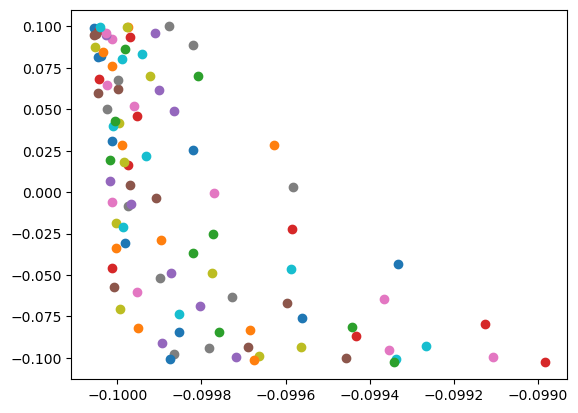

In [183]:
for pc in pcs.T:
    plt.scatter(np.real(pc[0]), np.real(pc[1]))

In [136]:
X.shape[0]

26935

In [167]:
100*s**2/sum(s**2)

array([9.67289474e+01, 2.60451945e+00, 5.94317110e-01, 5.27437090e-02,
       1.82118244e-02, 9.69367573e-04, 1.78265512e-04, 4.89669949e-05,
       3.62089097e-05, 1.69369700e-05, 7.46068652e-06, 1.87091046e-06,
       7.13718068e-07, 2.85251865e-07, 2.54010662e-07, 9.73362314e-08,
       7.04628960e-08, 1.59713435e-08, 5.28447502e-09, 4.19824949e-09,
       2.56583017e-09, 1.59685700e-09, 1.15503952e-09, 2.56553972e-10,
       1.64305927e-10, 6.24855945e-11, 4.12060337e-11, 3.13075912e-11,
       1.98359171e-11, 1.16990615e-11, 4.23146372e-12, 2.66888256e-12,
       1.74609106e-12, 1.02000206e-12, 8.63361882e-13, 3.57021848e-13,
       2.34797201e-13, 7.74346409e-14, 3.57826992e-14, 1.94894652e-14,
       1.58123086e-14, 1.10607355e-14, 8.10386601e-15, 5.82990593e-15,
       4.44289684e-15, 3.96198129e-15, 2.89818193e-15, 2.22338679e-15,
       7.42767011e-16, 3.13178559e-16, 1.68604147e-16, 1.15037597e-16,
       9.91401515e-17, 7.04874192e-17, 5.01689756e-17, 4.14321915e-17,
      

In [168]:
pcs[

array([[-0.10005508+0.00000000e+00j, -0.09997448+2.88309854e-03j,
        -0.10004059-2.40011771e-03j, -0.10004447+8.07812959e-04j,
        -0.09991124+4.04450594e-03j, -0.10005599-1.37104727e-03j,
        -0.10001249+1.95457812e-03j, -0.0998204 +5.31810889e-03j,
        -0.10005345+2.97776283e-05j, -0.09994194+3.47787019e-03j,
        -0.10004705-1.73237935e-03j, -0.10001216+1.81385469e-03j,
        -0.09980752+5.40904450e-03j, -0.10004301+3.38274728e-04j,
        -0.09990142+4.03956730e-03j, -0.10004598-9.33937749e-04j,
        -0.09996085+2.87708797e-03j, -0.10002351-2.21943696e-03j,
        -0.09999495+1.94240793e-03j, -0.10000991-2.81517481e-03j,
        -0.10001205+1.24513886e-03j, -0.09998887-3.38627242e-03j,
        -0.10001844+8.01232161e-04j, -0.09997401-3.70723540e-03j,
        -0.1000183 +6.18419519e-04j, -0.09996878-3.76930200e-03j,
        -0.10001336+6.97345819e-04j, -0.09997403-3.56280860e-03j,
        -0.10000248+1.04371281e-03j, -0.09998726-3.09056267e-03j,
        -0

In [176]:
abs(pcs.T[25])

array([0.10003981, 0.09843039, 0.10002869, 0.09902042, 0.1128431 ,
       0.09823892, 0.04394746, 0.04688193, 0.11059116, 0.09960271,
       0.10807479, 0.08394999, 0.00360411, 0.12776865, 0.08543179,
       0.07651582, 0.02605941, 0.06439397, 0.07204624, 0.04338377,
       0.10687418, 0.09691322, 0.07743416, 0.07176184, 0.05112633,
       0.10097269, 0.08780724, 0.06385777, 0.07516528, 0.09304049,
       0.01376144, 0.01730197, 0.08462575, 0.11039223, 0.04478848,
       0.10907238, 0.04279351, 0.06593263, 0.054933  , 0.0809912 ,
       0.05268947, 0.13546188, 0.07760885, 0.10113587, 0.07309242,
       0.09661311, 0.03394621, 0.05033758, 0.08100588, 0.06048675,
       0.14164343, 0.06349767, 0.08616823, 0.0936146 , 0.12693368,
       0.04549855, 0.13028343, 0.02299371, 0.00546281, 0.0498387 ,
       0.10087269, 0.03861029, 0.05046011, 0.11443415, 0.06678126,
       0.0669907 , 0.0477198 , 0.07519227, 0.06647471, 0.07869488,
       0.27339504, 0.22389772, 0.0275185 , 0.05435722, 0.10514

In [157]:
X[0]

array([9.11008529e-20-1.02727705e-20j, 9.09000317e-20-1.20156367e-20j,
       9.16603093e-20-3.96835093e-21j, 9.16289032e-20-6.09657616e-21j,
       9.15776514e-20-8.28091130e-21j, 9.21257968e-20-1.18034257e-22j,
       9.22855378e-20-2.46165839e-21j, 9.24157579e-20-4.89385765e-21j,
       9.27873758e-20+3.08691717e-21j, 9.31368095e-20+4.76451967e-22j,
       9.31402549e-20+8.32778792e-21j, 9.37212396e-20+5.51179512e-21j,
       9.42538762e-20+2.55276156e-21j, 9.42333481e-20+1.01592684e-20j,
       9.50014677e-20+6.95242066e-21j, 9.47418494e-20+1.43639352e-20j,
       9.57534365e-20+1.08844008e-20j, 9.52695467e-20+1.83207320e-20j,
       9.65775521e-20+1.42821998e-20j, 9.60280656e-20+2.12262676e-20j,
       9.75372553e-20+1.70880685e-20j, 9.69420937e-20+2.37536180e-20j,
       9.86896746e-20+1.92322051e-20j, 9.81098677e-20+2.56056962e-20j,
       1.00078708e-19+2.06455884e-20j, 9.95710213e-20+2.67106869e-20j,
       1.01728861e-19+2.12607737e-20j, 1.01345657e-19+2.69880845e-20j,
      